# CNN in CIFAR10

In this notebook, we will use the CIFAR10 dataset to train a CNN. 

It has the classes:

- airplane

- bird

- cat

- deer

- dog

- frog

- horse

- ship

- truck

The images in CIFAR10 are of size $3 \times 32 \times 32$, i.e. 3-channel color images of $32 \times 32$ pixels in size.

## Training an image classifier

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using `torchvision`

2. Define a Convolutional Neural Network

3. Define a loss function

4. Train the network on the training data

5. Test. the network on the test data

## 1. Loading and normalizing CIFAR10

Using `torchvision`, it's extremely easy to load CIFAR10.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to tensors of normalized range [-1, 1].

In [2]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='../data', 
                                                        train=True,
                                                        download=True,
                                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, 
                                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../data',
                                                       train=False,
                                                       download=True,
                                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, 
                                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird','cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.

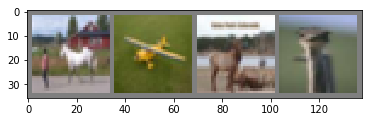

horse plane  deer  bird


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5      # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))    

## 2. Define a Convolutional Neural Network

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

## 3. Define a Loss function and optimizer

Let us use a Classification Cross-Entropy loss and SGD with momentum

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4. Train the network

We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [7]:
for epoch in range(2):      # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        # zero the parameters gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:      # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i+1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.212
[1,  4000] loss: 1.874
[1,  6000] loss: 1.676
[1,  8000] loss: 1.588
[1, 10000] loss: 1.511
[1, 12000] loss: 1.468
[2,  2000] loss: 1.397
[2,  4000] loss: 1.386
[2,  6000] loss: 1.361
[2,  8000] loss: 1.318
[2, 10000] loss: 1.321
[2, 12000] loss: 1.297
Finished Training


## 5. Test the network on the test data

First step, let's display an image from the test set to get familiar.

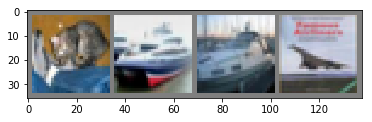

GroundTruth:    cat  ship  ship plane


In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:

In [10]:
outputs = net(images)

The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:

In [11]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:   frog  ship  ship  ship


Let us look at the network performs on the whole dataset.

In [16]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


That looks way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did not perform well:

In [17]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for images, labels in testloader:
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 65 %
Accuracy of   car : 57 %
Accuracy of  bird : 40 %
Accuracy of   cat : 37 %
Accuracy of  deer : 48 %
Accuracy of   dog : 19 %
Accuracy of  frog : 73 %
Accuracy of horse : 64 %
Accuracy of  ship : 60 %
Accuracy of truck : 72 %
